## 信用卡欺诈检测

这案例是基于kaggle的比赛，Fraud Detection in Credit Card； 
https://www.kaggle.com/mlg-ulb/creditcardfraud  
信用卡诈骗的情况从申请到使用都会有，一种是在申请的时候使用各种虚假信息，并欺骗隐瞒真实的用途； 一种是透支，但是要和养卡逾期区分，逾期一次一般不能超过一周，不然会记录到征信系统，如果多次逾期，并且透支后没有还就可能被判为欺诈。还有一种是别人通过复制伪造，偷取密码信息冒用他人的信用卡，在未经主人同意下恶意透支等行为。总体看最终都是要进行盗刷的步骤，也是最终目的，所以交易数据是最为重要的判断依据。  
![image.png](creditcard.png)

### 背景和数据

kaggle的数据来自2013年欧洲的卡管公司的信用卡交易数据，数据是极度不平衡的，总共284,807个样本，fraud为0的数据集为284,315，而正样本即fraud为1的数据有只有492。数据集已经过很好的特征处理，有Time特征， 和第一次交易的时间间隔；Amount为交易量，其他v1到v28是脱敏数据，这也是最为重要的核心机密，而且是经过了PCA降维获得的主要特征，归一化也比较好了，所以数据的特征处理相对简单。项目的重点是异常检测和不平衡样本处理。

这里主要是处理样本不平衡问题。主要参考：  
https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets  
https://blog.csdn.net/s09094031/article/details/90924284  
https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve  
https://www.biaodianfu.com/lightgbm.html  
https://www.cnblogs.com/jiangxinyang/p/9337094.html  
https://blog.csdn.net/weiyongle1996/article/details/78446244/  
https://baijiahao.baidu.com/s?id=1651191646213921996&wfr=spider&for=pc

## 数据读取

In [61]:
# -*- coding: UTF-8 -*-
"""
样本不平衡处理案例
信用卡欺诈检测
"""

# 保证脚本与Python3兼容
from __future__ import print_function

import os   #读取数据文件
import sys
import pymysql 
from sqlalchemy import create_engine
 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split  #划分训练集测试集使用
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.linear_model import LogisticRegression ,LogisticRegressionCV
#from sklearn.linear_model.coordinate_descent import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer #特征转换器
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from collections import Counter

%matplotlib inline 

import warnings

warnings.filterwarnings("ignore")

def readData(path):
    """
    使用pandas读取数据
    """
    data = pd.read_csv(path)
    cols = list(data.columns.values)
    return data[cols]
 

def visualize(ratios, predPositive, truePositive, aucs, accuracies):
    """
    将模型结果可视化
    """
    # 为在Matplotlib中显示中文，设置特殊字体
    plt.rcParams["font.sans-serif"]=["SimHei"]
    # 创建一个图形框
    fig = plt.figure(figsize=(12, 6), dpi=80)
    # 在图形框里画两幅图
    ax = fig.add_subplot(1, 2, 1)
    # 在Python3中，str不需要decode
    if sys.version_info[0] == 3:
        ax.plot(ratios, predPositive,
            label="%s" % "预测结果里类别1的个数")
        ax.plot(ratios, truePositive, "k--",
            label="%s" % "原始数据里类别1的个数")
    else:
        ax.plot(ratios, predPositive,
            label="%s" % "预测结果里类别1的个数".decode("utf-8"))
        ax.plot(ratios, truePositive, "k--",
            label="%s" % "原始数据里类别1的个数".decode("utf-8"))
    ax.set_xlim([0, 0.5])
    ax.invert_xaxis()
    legend = plt.legend(shadow=True, loc="best")
    ax1 = fig.add_subplot(1, 2, 2)
    # 在Python3中，str不需要decode
    if sys.version_info[0] == 3:
        ax1.plot(ratios, aucs, "r", label="%s" % "曲线下面积（AUC）")
        ax1.plot(ratios, accuracies, "k-.", label="%s" % "准确度（ACC）")
    else:
        ax1.plot(ratios, aucs, "r", label="%s" % "曲线下面积（AUC）".decode("utf-8"))
        ax1.plot(ratios, accuracies, "k-.", label="%s" % "准确度（ACC）".decode("utf-8"))
    ax1.set_xlim([0, 0.5])
    ax1.set_ylim([0.5, 1])
    ax1.invert_xaxis()
    legend = plt.legend(shadow=True, loc="best")
    plt.show()

def sample_class_show(y,savepath='res.png'):
    '''
    绘制饼图，y是标签列表
    '''
    target_stats=Counter(y)
    labels=list(target_stats.keys())
    sizes = list(target_stats.values())
    explode=tuple([0.1]*len(target_stats))
    fig,ax  = plt.subplots()
    ax.pie(sizes,explode=explode,labels=labels,shadow=True,autopct='%1.1f%%')
    ax.axis('equal')
    plt.savefig(savepath)    

 
    
if __name__ == "__main__":
    # 设置显示格式
    pd.set_option('display.width', 1000)
    homePath = os.path.dirname(os.path.abspath('__file__'))
    # Windows下的存储路径与Linux并不相同
    if os.name == "nt":
        dataPath = "%s\\creditcard.csv" % homePath
    else:
        dataPath = "%s/creditcard.csv" % homePath
    credit = readData(dataPath)

In [20]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [21]:
credit.shape

(284807, 31)

Counter({0: 284315, 1: 492})


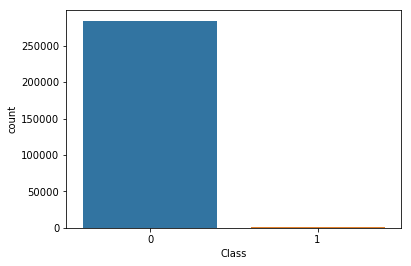

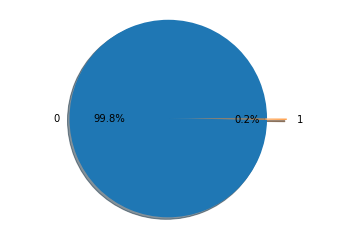

In [22]:
import seaborn as sns 
sns.countplot(x='Class',data=credit) #对不同值的 'Survived' 进行计数并绘图
from collections import Counter
# 查看样本类别分布， 
print(Counter(credit['Class']))

#画饼图
sample_class_show(credit['Class'],savepath='label_distribution.png')

(0.0, 172792.0)

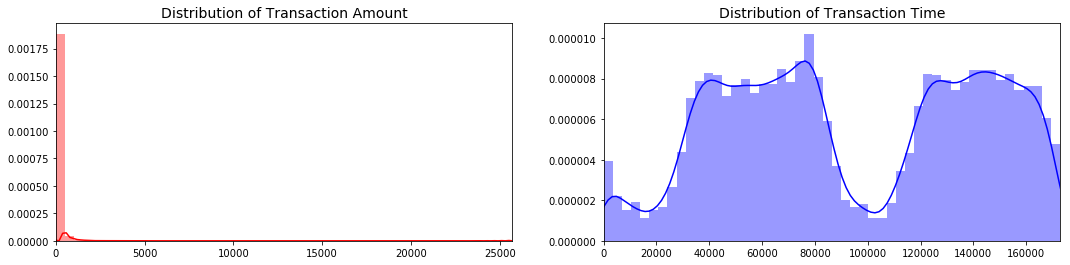

In [23]:
#接下来可以看看没脱敏的金额和时间的分布情况
fig,ax = plt.subplots(1,2,figsize=(18,4))

amount_val = credit['Amount'].values
time_val = credit['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

## 标准化和分布
接下来，我们首先把Amount和Time这两列也标准化。同时我们也需要开始对数据做将降采样 - 使得好坏样本的数量相等，这可以让我们的算法在识别欺诈交易的时候能够更有信心


In [24]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()   #x'=(x-min)/(max-min)
#标准化放在新的列
credit['scaled_amount'] = rob_scaler.fit_transform(credit['Amount'].values.reshape(-1,1)) 
credit['scaled_time'] = rob_scaler.fit_transform(credit['Time'].values.reshape(-1,1))

credit.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = credit['scaled_amount']
scaled_time = credit['scaled_time']
# insert 可以把新加的列插到前面
credit.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
credit.insert(0, 'scaled_amount', scaled_amount)
credit.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

credit.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


###  划分训练集、验证集
分层抽样

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

print('No Frauds', round(credit['Class'].value_counts()[0]/len(credit) * 100,2), '% of the dataset')
print('Frauds', round(credit['Class'].value_counts()[1]/len(credit) * 100,2), '% of the dataset')

X = credit.drop('Class',axis=1)
y = credit['Class']

sss = StratifiedKFold(n_splits=5,random_state=None,shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
#转为数组以便建模    
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


## 不平衡处理
### 随机下采样

In [26]:
# 这里的sample起的是shuffle的作用
credit = credit.sample(frac=1) #打乱

# 取和少数正样本一样的数量.
fraud_df = credit.loc[credit['Class'] == 1]
non_fraud_df = credit.loc[credit['Class'] == 0][:492]  #取前492个

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
170600,0.010480,0.417874,2.039132,-0.178133,-1.386238,0.227548,0.203084,-0.632991,0.157569,-0.221065,...,-0.156682,-0.250727,-0.626497,0.298569,0.623209,-0.205740,0.365243,-0.087787,-0.056447,0
57248,-0.201495,-0.433111,-0.887287,1.390002,1.219686,1.661425,1.009228,-0.733908,0.855829,0.000077,...,-0.268347,-0.083734,-0.346930,-0.050619,0.231044,-0.450760,-0.376205,0.034504,0.157775,1
259516,1.395375,0.874740,1.802861,-0.905121,-2.586890,-0.783619,2.114923,3.502515,-0.469054,0.813151,...,0.071052,-0.097600,-0.405025,0.152254,0.721255,-0.071332,-0.080277,-0.027465,-0.042088,0
249167,20.721442,0.817514,-1.600211,-3.488130,-6.459303,3.246816,-1.614608,-1.260375,0.288223,-0.048964,...,3.189355,1.191175,-0.967141,-1.463421,-0.624231,-0.176462,0.400348,0.152947,0.477775,1
88876,-0.293440,-0.262715,1.140865,1.221317,-1.452955,2.067575,0.854742,-0.981223,0.325714,-0.037721,...,-0.067712,-0.377597,-0.793460,-0.132333,-0.331586,0.664878,-0.309312,0.099942,0.122988,1


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


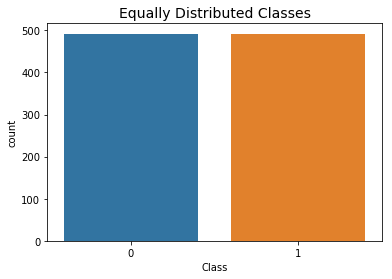

In [27]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

####  相关矩阵
从下图相关矩阵图可以看出，越是蓝色是正相关，越是红色是负相关。  
在经过降采样处理后的相关性，取出比较深的几个特征。  
负相关：V17, V14, V12 V10  
正相关：V2, V4, V11, V19  
    在解决不平衡问题之前，大多数特征并没有显示出相关性，这肯定会影响模型的性能。所以解决不平衡可以使得特征相关性更明显。 特征性相关性还会影响ML模型的性能，因此修复类别不平衡问题非常重要。

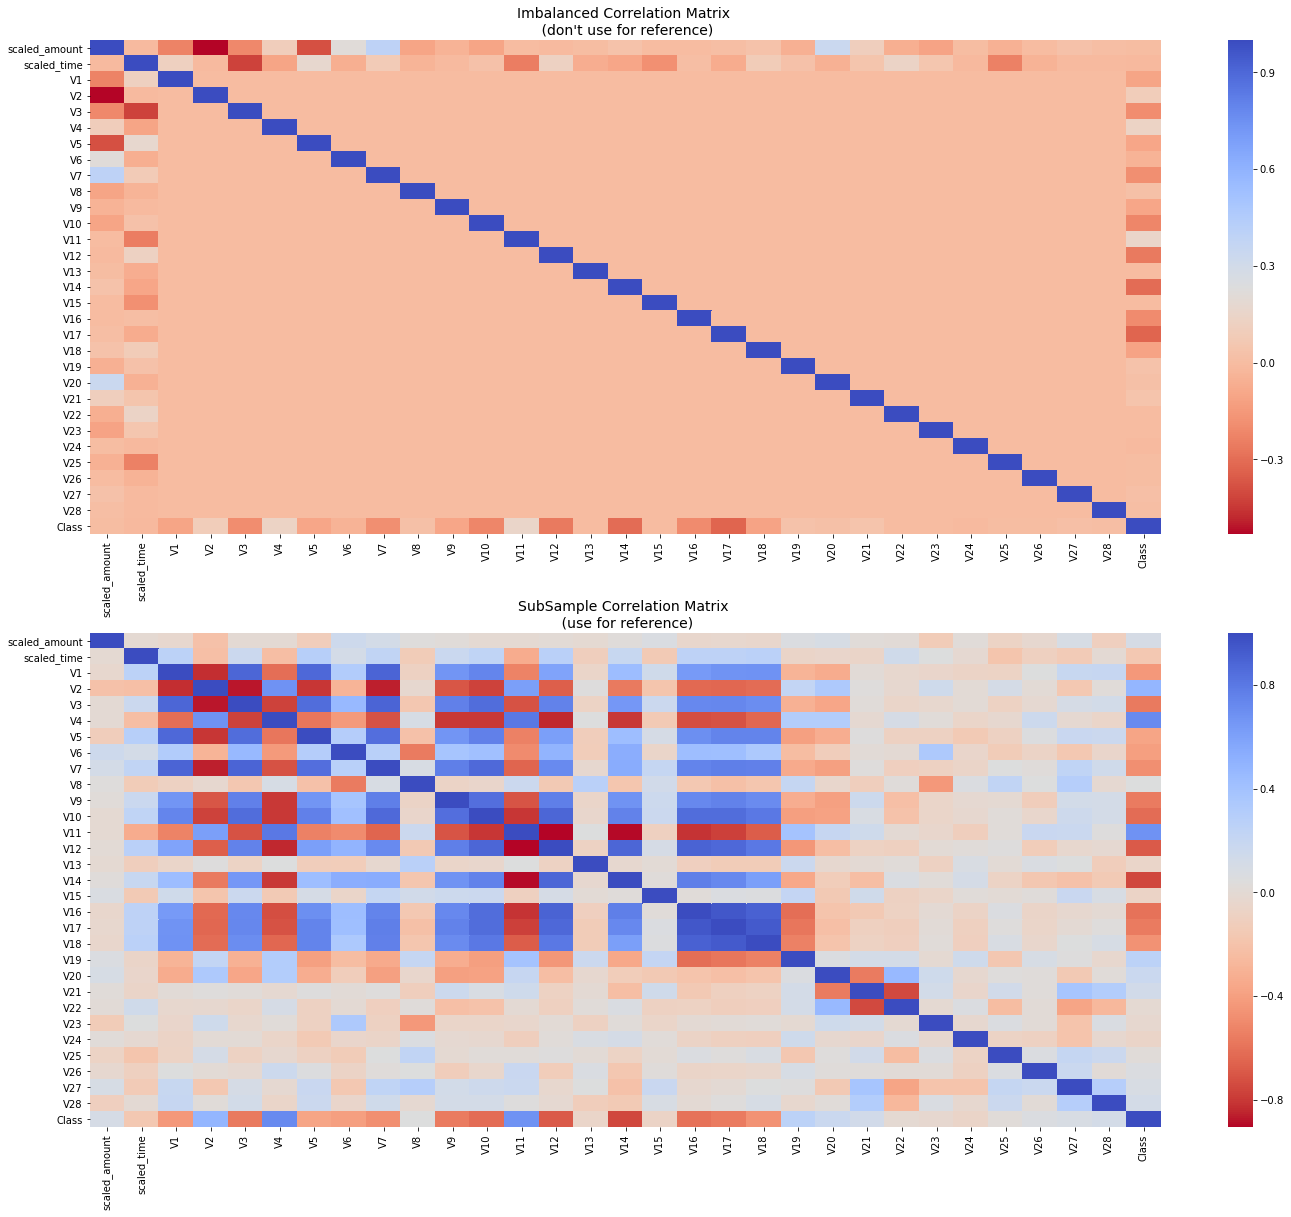

In [28]:
fig , (ax1,ax2) = plt.subplots(2,1,figsize=(24,20))

#原始不平衡数据特征相关性
corr = credit.corr()
sns.heatmap(corr,cmap='coolwarm_r',annot_kws={'size':20},ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

#降采样后的数据特征相关性
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

## 异常值处理
箱线法对极值超过百分位的1.5倍的方式做处理，这里都是删除

In [29]:
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-19.2143254902614, -18.049997689859396, -18.4937733551053, -18.8220867423816]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.4311310279993, -18.047596570821604, -18.553697009645802, -18.683714633344298]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-18.9132433348732, -

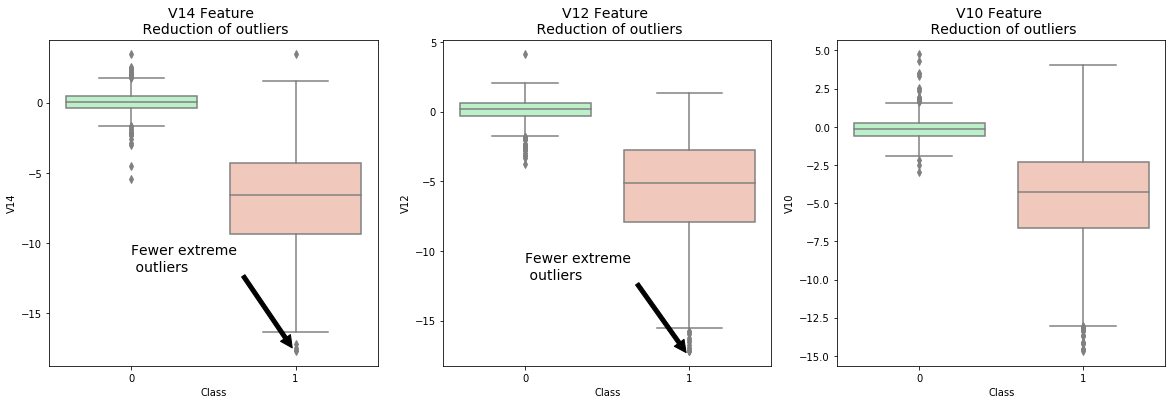

In [30]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

## 使用分类器

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X = new_df.drop('Class',axis=1)
y = new_df['Class']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key,classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 94.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 92.0 % accuracy score


In [32]:
#来通过网格搜索精细化的调个参试试
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.8%
Knears Neighbors Cross Validation Score 93.67%
Support Vector Classifier Cross Validation Score 93.54%
DecisionTree Classifier Cross Validation Score 93.01%


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

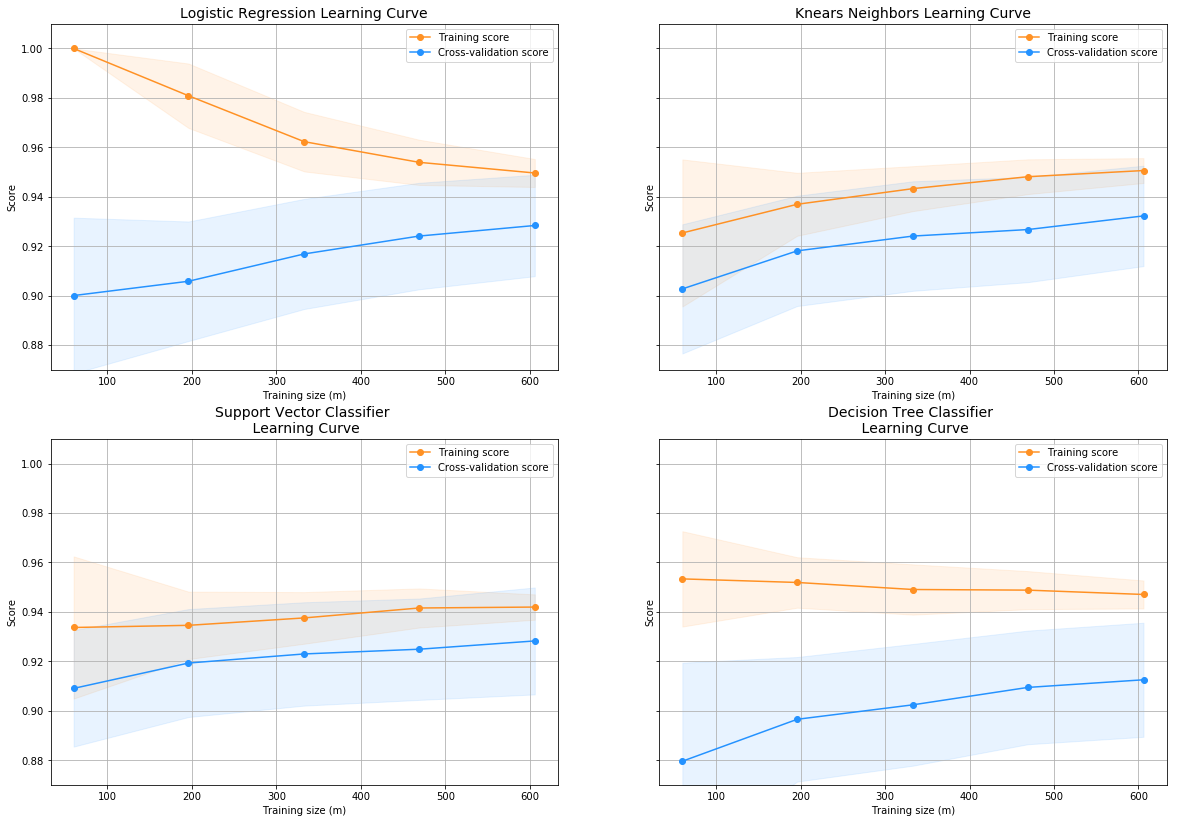

In [33]:
#学习曲线
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)


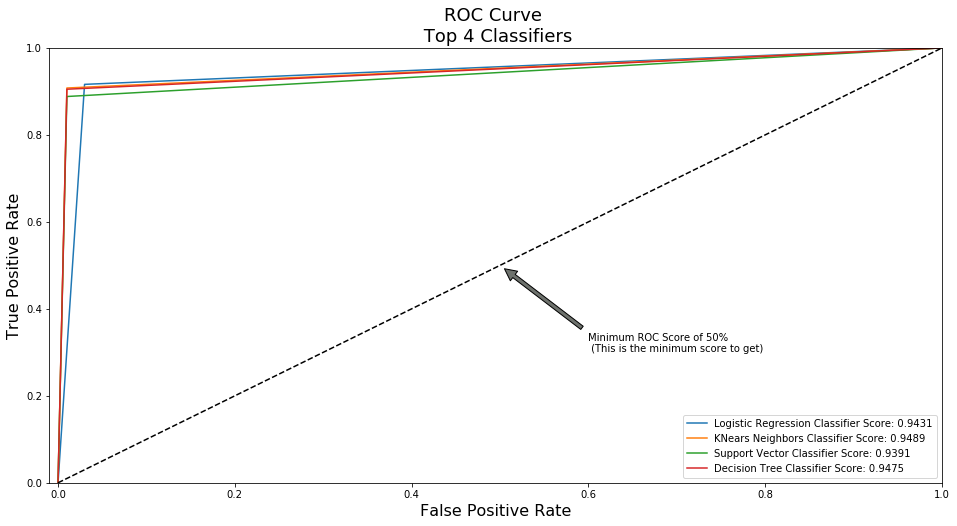

In [34]:
#ROC曲线,不平衡数据建议使用roc
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score, classification_report,roc_curve
log_reg_pred = log_reg.predict(X_train)
knears_pred = knears_neighbors.predict(X_train)
svc_pred = svc.predict(X_train)
tree_pred = tree_clf.predict(X_train)

log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()


### 原型生成(prototype generation)
给定数据集S, 原型生成算法将生成一个子集S’, 其中|S’| < |S|, 但是子集并非来自于原始数据集. 意思就是说: 原型生成方法将减少数据集的样本数量, 剩下的样本是由原始数据集生成的, 而不是直接来源于原始数据集.

ClusterCentroids函数实现了上述功能: 每一个类别的样本都会用K-Means算法的中心点来进行合成, 而不是随机从原始样本进行抽取.
 

In [ ]:
#原型生成,但要跑挂了
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_sample(X, y)

print(sorted(Counter(y_resampled).items()))

### 原型选择(prototype selection)
与原型生成不同的是, 原型选择算法是直接从原始数据集中进行抽取. 抽取的方法大概可以分为两类: (i) 可控的下采样技术(the controlled under-sampling techniques) ; (ii) the cleaning under-sampling techniques( 清洗的下采样技术). 第一类的方法可以由用户指定下采样抽取的子集中样本的数量; 第二类方法则不接受这种用户的干预. 

In [3]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X = credit.drop('Class',axis=1)
y = credit['Class']
X_resampled, y_resampled = rus.fit_sample(X, y)

print(sorted(Counter(y_resampled).items())) 

[(0, 492), (1, 492)]


In [4]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X, y)

print(sorted(Counter(y_resampled).items()))
 
#np.vstack({tuple(row) for row in X_resampled}).shape 
#NearMiss函数则添加了一些启发式(heuristic)的规则来选择样本, 通过设定version参数来实现三种启发式的规则.
#NearMiss-1: 选择离N个近邻的负样本的平均距离最小的正样本;

#NearMiss-2: 选择离N个负样本最远的平均距离最小的正样本;

#NearMiss-3: 是一个两段式的算法. 首先, 对于每一个负样本, 保留它们的M个近邻样本; 接着, 那些到N个近邻样本平均距离最大的正样本将被选择.
from imblearn.under_sampling import NearMiss
nm1 = NearMiss( version=1)
X_resampled_nm1, y_resampled = nm1.fit_sample(X, y) 
print(sorted(Counter(y_resampled).items()))

[(0, 492), (1, 492)]
[(0, 492), (1, 492)]


### 过采样
#### SMOTE和ADASYN
Synthetic Minority Oversampling Technique (SMOTE)  
Adaptive Synthetic (ADASYN) .  
随机过采样可能导致信息偏差，就是样本会偏向某些形态的部分，而有的形态的样本变少了 ，所以有了SMOTE和ADASYN  
SMOTE: 对于少数类样本a, 随机选择一个最近邻的样本b, 然后从a与b的连线上随机选取一个点c作为新的少数类样本;  
ADASYN: 关注的是在那些基于K最近邻分类器被错误分类的原始样本附近生成新的少数类样本  
虽然上采样会比降采样效果好，但也更加耗时

In [6]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled_smote, y_resampled_smote = SMOTE().fit_sample(X, y)

sorted(Counter(y_resampled_smote).items())
 

X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_sample(X, y)
print(sorted(Counter(y_resampled_smote).items()))


[(0, 284315), (1, 284315)]


In [38]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

log_reg_sm = LogisticRegression()   
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)  #随机搜索最优参数


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)


Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9418034688807193
precision: 0.061029071605382554
recall: 0.9137617656604998
f1: 0.11267514587757929
---------------------------------------------------------------------------------------------------------------------------------------


In [40]:
#预测
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.10      0.86      0.17        98

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.58     56961
weighted avg       1.00      0.99      0.99     56961



In [46]:
y_score = best_est.decision_function(original_Xtest)

In [48]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.70


可以看出过采样整体准确率更好


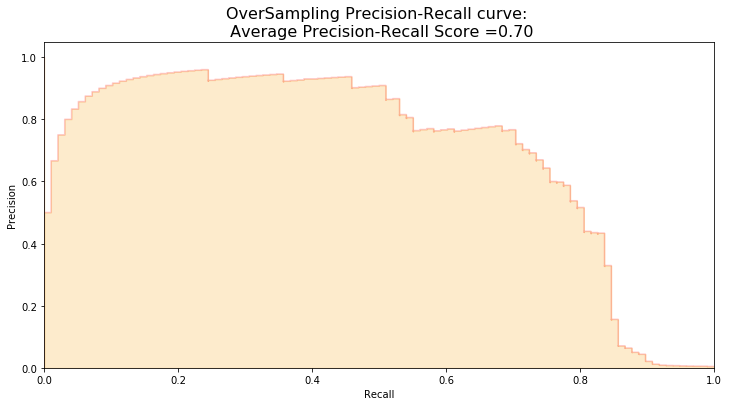

In [49]:
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score, classification_report,precision_recall_curve

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16);

In [45]:
#最后在全量数据及下跑个准确率
from sklearn.metrics import accuracy_score

# 带Under-Sampling的Logistic Regression   
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred) 
recall_s1 = recall_score(y_test,y_pred)


# 带SMOTE的Logistic Regression，
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)
recall_s2 = recall_score(original_ytest,y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score],
    'Recall':[recall_s1,recall_s2]}
final_df = pd.DataFrame(data=d)

# 移动列
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df


 

,Technique,Score,Recall
0,Random UnderSampling,0.963158,0.929293
1,Oversampling (SMOTE),0.986026,0.857143


- True Positives:  正确分类的Fraud交易
- False Positives: 错分的Fraud交易
- True Negative: 正确分类的Non-Fraud交易
- False Negative: 错分的Non-Fraud交易
- Precision: True Positives/(True Positives + False Positives)
- Recall: True Positives/(True Positives + False Negatives)  
可以看出过采样可以获得更多正确分类，但同时会带来更小的召回率。召回度量有多个正例被分为正例，也即是检测的灵敏度，这样从业务角度应该需要更大的召回率，正确率可以牺牲点。所以这里更推荐使用Precision/Recall 曲线而不是ROC

### 再缩放或代价敏感
用不改变样本量的方式，即设置权重，使正样本的分错代价更大，也就是类似代价敏感的方式。
#### 使用balanced
LogisticRegression()有一个参数class_weight，默认值为None，这测试设置为 ‘balanced’。从结果来看，这个weight是根据class的比例来确定的，约为577。  


Recall metric in the testing dataset:  0.8673469387755102


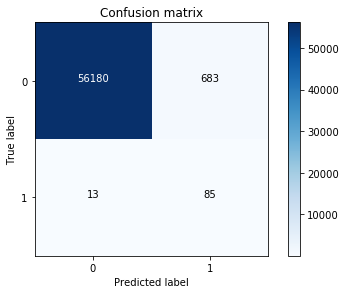

In [56]:
from sklearn.metrics import confusion_matrix,recall_score,classification_report 
import itertools


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
lr_model = LogisticRegression(class_weight = 'balanced')
lr_model.fit(original_Xtrain,original_ytrain)
y_pred = lr_model.predict(original_Xtest)

# Compute confusion matrix
cnf_matrix = confusion_matrix(original_ytest,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()


#plotConfusionMatrixClassificationReport(original_ytest, y_pred, len_class0, len_class1) 

#### 设置权重，使用不同的权重
本次实验，对LogisticRegression()中的class_weight 设置具体的权重参数。其中class0的权重始终为1，而class1的权重为[1,5,10,50,100,500]。分析不同权重对分类器的影响。结果显示当class1的权重为5或者10的时候，precision和recall能取得比较好的平衡，当权重为5或500时，AUC(PR)较大。
 


weight is 1 for fraud class --
weight is 5 for fraud class --
weight is 10 for fraud class --
weight is 50 for fraud class --
weight is 100 for fraud class --
weight is 500 for fraud class --
weight is 1 for fraud class --
the precision score is, <function precision_score at 0x7ff8401cfcb0>
the recall score is, <function recall_score at 0x7ff8401cfd40>
the pr score is, 0.7451576611088965
weight is 5 for fraud class --
the precision score is, <function precision_score at 0x7ff8401cfcb0>
the recall score is, <function recall_score at 0x7ff8401cfd40>
the pr score is, 0.782231972968149
weight is 10 for fraud class --
the precision score is, <function precision_score at 0x7ff8401cfcb0>
the recall score is, <function recall_score at 0x7ff8401cfd40>
the pr score is, 0.7809747401915021
weight is 50 for fraud class --
the precision score is, <function precision_score at 0x7ff8401cfcb0>
the recall score is, <function recall_score at 0x7ff8401cfd40>
the pr score is, 0.7453258439235343
weight is 1

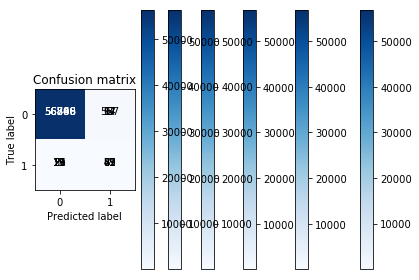

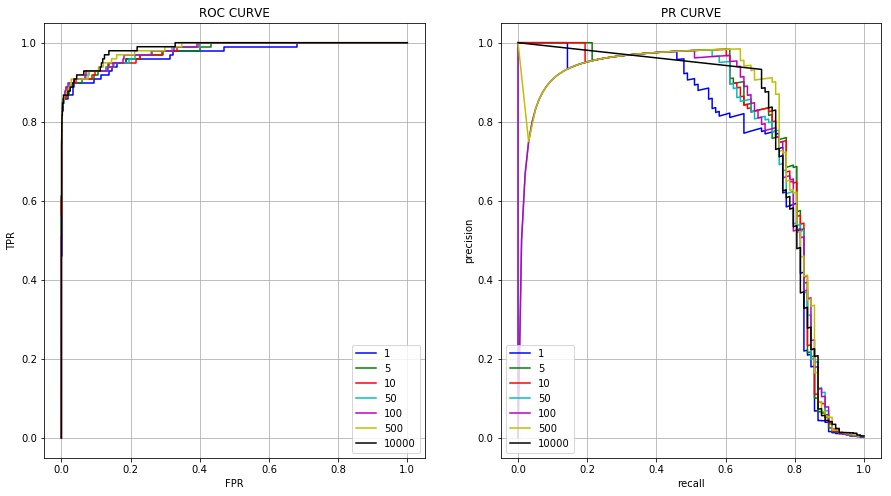

In [62]:
from sklearn.metrics import auc 
for w in [1,5,10,50,100,500]:
    print('weight is {} for fraud class --'.format(w))
    lr_model = LogisticRegression(class_weight = {0:1,1:w})
    lr_model.fit(original_Xtrain,original_ytrain)
    y_pred = lr_model.predict(original_Xtest)
    #plotConfusionMatrixClassificationReport(original_ytest, y_pred, len_class0, len_class1)
    cnf_matrix = confusion_matrix(original_ytest,y_pred)
    #np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
    
##
fig = plt.figure(figsize = [15,8]) 
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('ROC CURVE')
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('FPR')
ax1.set_ylabel('TPR')
plt.grid()

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('PR CURVE')
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('recall')
ax2.set_ylabel('precision')
plt.grid()
for w,k in zip([1,5,10,50,100,500,10000], 'bgrcmykw'):
    lr_model = LogisticRegression(class_weight = {0:1,1:w})
    lr_model.fit(original_Xtrain,original_ytrain)
    y_pred = lr_model.predict(original_Xtest)
    y_pred_prob = lr_model.predict_proba(original_Xtest)[:,1]
    p,r,_ = precision_recall_curve(original_ytest, y_pred_prob)
    fpr, tpr,_ = roc_curve(original_ytest, y_pred_prob)
    precision = precision_score(original_ytest, y_pred)
    recall = recall_score(original_ytest, y_pred)
    roc_score = roc_auc_score(original_ytest, y_pred_prob)
    pr_score = auc(r,p)
    print('weight is {} for fraud class --'.format(w))
    print('the precision score is,',precision_score )
    print('the recall score is,',recall_score )
    print('the pr score is,', pr_score)
    ax1.plot(fpr, tpr, c=k, label = w)
    ax2.plot(r,p, c = k, label = w)
ax1.legend(loc = 'lower right')
ax2.legend(loc = 'lower left')
plt.show() 

####  LightGBM处理样本类别分布不均衡的问题 

lightGBM是常用的集成算法，自带有处理非平衡的方法，一个简单的方法是设置is_unbalance参数为True或者设置scale_pos_weight,二者只能选一个。
设置is_unbalance参数为True时会把负样本的权重设为：正样本数/负样本数。这个参数只能用于二分类。 
- scale_pos_weight： 一个浮点数，用于调整正样本的权重，默认值为0它用于二分类任务。
- is_unbalance或者unbalanced_set ： 一个布尔值，指示训练数据是否均衡的。默认为True。它用于二分类任务。


weight is 0.1 for fraud class --
the precision score is, <function precision_score at 0x7ff8401cfcb0>
the recall score is, <function recall_score at 0x7ff8401cfd40>
the pr score is, 0.6416716979341994
weight is 0.2 for fraud class --
the precision score is, <function precision_score at 0x7ff8401cfcb0>
the recall score is, <function recall_score at 0x7ff8401cfd40>
the pr score is, 0.6559744192477284
weight is 0.3 for fraud class --
the precision score is, <function precision_score at 0x7ff8401cfcb0>
the recall score is, <function recall_score at 0x7ff8401cfd40>
the pr score is, 0.6705297705789662
weight is 0.4 for fraud class --
the precision score is, <function precision_score at 0x7ff8401cfcb0>
the recall score is, <function recall_score at 0x7ff8401cfd40>
the pr score is, 0.6857046167270248
weight is 0.5 for fraud class --
the precision score is, <function precision_score at 0x7ff8401cfcb0>
the recall score is, <function recall_score at 0x7ff8401cfd40>
the pr score is, 0.701410043969

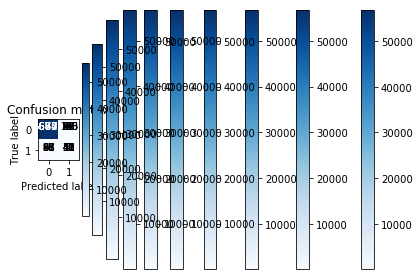

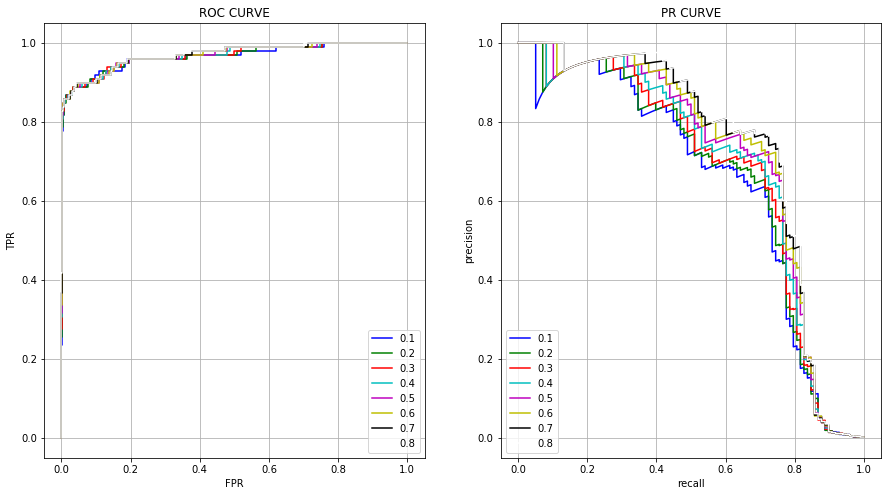

In [72]:
import lightgbm as lgb

#可以看到调整后逐渐增加的准确率
for w in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    lgbm = lgb.sklearn.LGBMClassifier(scale_pos_weight=w)
    lgbm.fit(original_Xtrain,original_ytrain)
    y_pred = lgbm.predict(original_Xtest)
    #plotConfusionMatrixClassificationReport(original_ytest, y_pred, len_class0, len_class1)
    cnf_matrix = confusion_matrix(original_ytest,y_pred)
    #np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix') 

fig = plt.figure(figsize = [15,8]) 
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('ROC CURVE')
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('FPR')
ax1.set_ylabel('TPR')
plt.grid()

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('PR CURVE')
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('recall')
ax2.set_ylabel('precision')
plt.grid()
for w,k in zip([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 'bgrcmykw'):
    lr_model = LogisticRegression(class_weight = {0:1,1:w})
    lr_model.fit(original_Xtrain,original_ytrain)
    y_pred = lr_model.predict(original_Xtest)
    y_pred_prob = lr_model.predict_proba(original_Xtest)[:,1]
    p,r,_ = precision_recall_curve(original_ytest, y_pred_prob)
    fpr, tpr,_ = roc_curve(original_ytest, y_pred_prob)
    precision = precision_score(original_ytest, y_pred)
    recall = recall_score(original_ytest, y_pred)
    roc_score = roc_auc_score(original_ytest, y_pred_prob)
    pr_score = auc(r,p)
    print('weight is {} for fraud class --'.format(w))
    print('the precision score is,',precision_score )
    print('the recall score is,',recall_score )
    print('the pr score is,', pr_score)
    ax1.plot(fpr, tpr, c=k, label = w)
    ax2.plot(r,p, c = k, label = w)
ax1.legend(loc = 'lower right')
ax2.legend(loc = 'lower left')
plt.show() 